### Metrics 4: Compare Eval Metrics

In [110]:
import pandas as pd
from matplotlib import pyplot as plt

In [111]:
!ls assets/metrics-dfs

metrics1-df-net3.csv   metrics2-df-rf.csv
metrics2-df-lasso.csv  metrics3-df-resnet.csv


In [112]:
d = 'assets/metrics-dfs/'
net3 =   pd.read_csv(d + 'metrics1-df-net3.csv')
lasso =  pd.read_csv(d + 'metrics2-df-lasso.csv')
rf =  pd.read_csv(d + 'metrics2-df-rf.csv')
resnet = pd.read_csv(d + 'metrics3-df-resnet.csv')


In [113]:
df = pd.concat((net3, lasso, rf, resnet), join='inner')

In [114]:
df

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
0,Net3,10 fit epochs,center,valid,0.002321,0.035860,0.529265,0.057386,0.430105,0.004642,0.625702
1,Net3,10 fit epochs,center,train,0.001251,0.026886,0.780596,0.042757,0.590545,0.002502,0.810111
2,Net3,10 fit epochs,topleft,valid,0.020588,0.103328,0.170152,0.166890,0.227500,0.041177,0.355698
3,Net3,10 fit epochs,topleft,train,0.014115,0.086962,0.388219,0.138814,0.409787,0.028231,0.628363
0,Lasso,alpha=1,topleft,train,0.005253,0.046936,0.909307,0.074546,0.750168,0.010506,0.910770
1,Lasso,alpha=1,center,train,0.001006,0.023437,0.920351,0.037478,0.740100,0.002012,0.920277
2,Lasso,alpha=1,topleft,valid,0.017655,0.081952,0.692450,0.130459,0.549808,0.035310,0.691744
3,Lasso,alpha=1,center,valid,0.001982,0.033595,0.842115,0.053305,0.629211,0.003964,0.842354
0,RF,default params,topleft,train,0.001585,0.018339,0.972602,0.030422,0.898043,0.003169,0.973085
1,RF,default params,center,train,0.000213,0.009108,0.983154,0.015020,0.895842,0.000425,0.983143


In [131]:
tmp = df[(df['split'] == 'valid') & (df['target'] == 'topleft')]
tmp.sort_values(by='dist_r2', ascending=False)

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
2,RF,default params,topleft,valid,0.009526,0.051479,0.834843,0.084943,0.706876,0.019053,0.833668
2,Lasso,alpha=1,topleft,valid,0.017655,0.081952,0.692450,0.130459,0.549808,0.035310,0.691744
0,ResNet18,90 fit epochs,topleft,valid,0.021076,0.094615,0.441618,0.159876,0.259965,0.042151,0.340451
2,Net3,10 fit epochs,topleft,valid,0.020588,0.103328,0.170152,0.166890,0.227500,0.041177,0.355698


In [132]:
tmp = df[(df['split'] == 'valid') & (df['target'] == 'center')]
tmp.sort_values(by='dist_r2', ascending=False)

,model,details,target,split,mse,mae,r2,dist_avg,dist_r2,sqdist_avg,sqdist_r2
3,RF,default params,center,valid,0.001620,0.026063,0.871394,0.041923,0.708388,0.003241,0.871118
3,Lasso,alpha=1,center,valid,0.001982,0.033595,0.842115,0.053305,0.629211,0.003964,0.842354
2,ResNet18,90 fit epochs,center,valid,0.003279,0.032108,0.425730,0.049895,0.504497,0.006558,0.471148
0,Net3,10 fit epochs,center,valid,0.002321,0.035860,0.529265,0.057386,0.430105,0.004642,0.625702


#### Compare R2 to MSE
Clearly somthing is wrong, it should be proportional

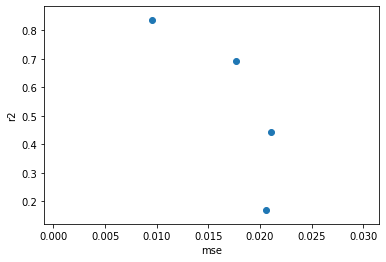

In [121]:
plt.scatter(tmp['mse'], tmp['r2'])
plt.xlabel('mse'); plt.ylabel('r2');

(0, 0.7)

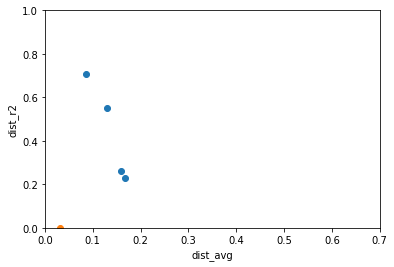

In [129]:
plt.scatter(tmp['dist_avg'], tmp['dist_r2'])
plt.scatter([0.032], [0])
plt.xlabel('dist_avg'); plt.ylabel('dist_r2');
plt.ylim(0,1)
plt.xlim(0, 0.7)

(0, 0.1)

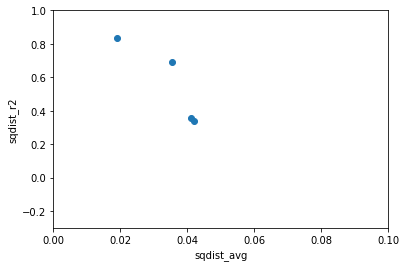

In [127]:
plt.scatter(tmp['sqdist_avg'], tmp['sqdist_r2'])
plt.xlabel('sqdist_avg'); plt.ylabel('sqdist_r2');
plt.ylim(-.3,1)
plt.xlim(0, 0.1)

In [42]:
baseline = 0.0322

In [59]:
x = 0.0199

In [64]:
x = 0.017655

In [65]:
((baseline - x) / baseline)**0.5

0.672092311021456